# Projet Knapsack Problem 0-1

**Équipe:** Chaabane, Arman, Bartosz, Ahmed

## Structure du projet

1. Infrastructure commune (Classes et structures de données)
2. Algorithmes implémentés
3. Système de benchmarking complet
4. Analyse comparative approfondie

---
## 1. Configuration et Imports

In [50]:
import time
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from pathlib import Path
from collections import defaultdict
from types import SimpleNamespace

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

# Palette de couleurs pour les algorithmes
ALGO_COLORS = {
    'Brute Force': '#e74c3c',
    'Dynamic Programming': '#3498db',
    'Branch and Bound': '#2ecc71',
    'Greedy Ratio': '#f39c12',
    'Greedy Value': '#9b59b6',
    'Greedy Weight': '#1abc9c',
    'Randomized': '#34495e',
    'Genetic Algorithm': '#e67e22',

    'Genetic Adaptive': '#d35400'}

---
## 2. Structures de Données Communes

In [51]:
class Item:
    """Représente un item avec son poids et sa valeur"""
    def __init__(self, item_id, weight, value):
        self.id = item_id
        self.weight = weight
        self.value = value
    
    def ratio(self):
        return self.value / self.weight if self.weight > 0 else 0
    
    def __repr__(self):
        return f"Item({self.id}, w={self.weight}, v={self.value})"


class Problem:
    """Représente une instance du problème de knapsack"""
    def __init__(self, items, capacity):
        self.items = items
        self.capacity = capacity
        self.n = len(items)


class Solution:
    """Représente une solution au problème"""
    def __init__(self, selected_items, total_value, total_weight, time_taken):
        self.selected_items = selected_items
        self.total_value = total_value
        self.total_weight = total_weight
        self.time = time_taken
        self.usage_percent = (total_weight / 1.0) * 100  # Sera mis à jour

---
## 3. Parsing et Gestion des Benchmarks

In [52]:
def parse_benchmark_file(filepath):
    """Parse un fichier benchmark .kp"""
    try:
        with open(filepath, 'r') as f:
            lines = [line.strip() for line in f.readlines() if line.strip()]
        
        n = int(lines[0])
        capacity = int(lines[1])
        
        items = []
        for i in range(n):
            parts = lines[2 + i].split()
            profit = int(parts[0])
            weight = int(parts[1])
            items.append(Item(i, weight, profit))
        
        return Problem(items, capacity)
    except Exception as e:
        print(f"Erreur parsing {filepath}: {e}")
        return None


def load_benchmark_structure():
    """
    Charge la structure complète des benchmarks.
    
    """
    base_path = Path('benchmarks')
    
    if not base_path.exists():
        print("Dossier 'benchmarks/' non trouvé")
        return None
    
    structure = {
        'correlations': ['uncorrelated', 'weakly_correlated', 'strongly_correlated'],
        'sizes': ['n50', 'n100', 'n500', 'n1000', 'n5000', 'n10000'],
        'capacities': ['r1000', 'r10000'],
        'benchmarks': {}
    }
    
    count = 0
    for correlation in structure['correlations']:
        for size in structure['sizes']:
            for capacity in structure['capacities']:
                filepath = base_path / correlation / size / capacity / 's000.kp'
                
                if filepath.exists():
                    key = f"{correlation}_{size}_{capacity}"
                    structure['benchmarks'][key] = {
                        'path': str(filepath),
                        'correlation': correlation,
                        'size': size,
                        'capacity': capacity,
                        'n': int(size[1:])  # Extrait le nombre de n50
                    }
                    count += 1
    
    print(f"✓ {count} benchmarks trouvés")
    return structure


# Charger la structure au démarrage
BENCHMARK_STRUCTURE = load_benchmark_structure()

✓ 36 benchmarks trouvés


---
## 4. Algorithmes Implémentés

### 4.1 Brute Force

In [53]:
def brute_force(problem):
    """Algorithme exhaustif O(2^n)"""
    start_time = time.time()
    
    best_value = 0
    best_weight = 0
    best_items = []
    
    for size in range(problem.n + 1):
        for combo in combinations(range(problem.n), size):
            total_weight = sum(problem.items[i].weight for i in combo)
            total_value = sum(problem.items[i].value for i in combo)
            
            if total_weight <= problem.capacity and total_value > best_value:
                best_value = total_value
                best_weight = total_weight
                best_items = list(combo)
    
    time_taken = time.time() - start_time
    sol = Solution(best_items, best_value, best_weight, time_taken)
    sol.usage_percent = (best_weight / problem.capacity) * 100 if problem.capacity > 0 else 0
    return sol

### 4.2 Programmation Dynamique

In [54]:
def dynamic_programming(problem):
    """Programmation dynamique O(n x C) avec protection"""
    start_time = time.time()
    
    n = problem.n
    C = problem.capacity
    
    total_cells = n * C
    if total_cells > 10_000_000:
        print(f"DP Skip: matrice trop grande ({n}×{C:,} = {total_cells:,})")
        return None
    
    estimated_mb = (total_cells * 8) / (1024 * 1024)
    if estimated_mb > 500:
        print(f"DP Skip: mémoire > 500 MB ({estimated_mb:.0f} MB)")
        return None
    
    dp = [[0 for _ in range(C + 1)] for _ in range(n + 1)]
    
    for i in range(1, n + 1):
        item = problem.items[i - 1]
        for w in range(C + 1):
            dp[i][w] = dp[i - 1][w]
            if item.weight <= w:
                dp[i][w] = max(dp[i][w], dp[i - 1][w - item.weight] + item.value)
    
    # Reconstruction
    selected = []
    w = C
    for i in range(n, 0, -1):
        if dp[i][w] != dp[i - 1][w]:
            selected.append(i - 1)
            w -= problem.items[i - 1].weight
    
    total_value = dp[n][C]
    total_weight = sum(problem.items[i].weight for i in selected)
    
    time_taken = time.time() - start_time
    sol = Solution(selected, total_value, total_weight, time_taken)
    sol.usage_percent = (total_weight / problem.capacity) * 100 if problem.capacity > 0 else 0
    return sol

### 4.3 Branch and Bound

In [55]:
def branch_and_bound(problem):
    """Branch and Bound avec élagage"""
    start_time = time.time()
    
    sorted_indices = sorted(range(problem.n), 
                          key=lambda i: problem.items[i].ratio(), 
                          reverse=True)
    
    best_value = 0
    best_solution = []
    
    def bound(level, current_weight, current_value):
        if current_weight >= problem.capacity:
            return 0
        
        value_bound = current_value
        total_weight = current_weight
        
        for i in range(level, problem.n):
            idx = sorted_indices[i]
            item = problem.items[idx]
            
            if total_weight + item.weight <= problem.capacity:
                total_weight += item.weight
                value_bound += item.value
            else:
                remaining = problem.capacity - total_weight
                value_bound += item.value * (remaining / item.weight)
                break
        
        return value_bound
    
    def branch(level, current_weight, current_value, current_items):
        nonlocal best_value, best_solution
        
        if level == problem.n:
            if current_value > best_value:
                best_value = current_value
                best_solution = current_items[:]
            return
        
        idx = sorted_indices[level]
        item = problem.items[idx]
        
        if current_weight + item.weight <= problem.capacity:
            new_value = current_value + item.value
            if bound(level + 1, current_weight + item.weight, new_value) > best_value:
                current_items.append(idx)
                branch(level + 1, current_weight + item.weight, new_value, current_items)
                current_items.pop()
        
        if bound(level + 1, current_weight, current_value) > best_value:
            branch(level + 1, current_weight, current_value, current_items)
    
    branch(0, 0, 0, [])
    
    total_weight = sum(problem.items[i].weight for i in best_solution)
    time_taken = time.time() - start_time
    
    sol = Solution(best_solution, best_value, total_weight, time_taken)
    sol.usage_percent = (total_weight / problem.capacity) * 100 if problem.capacity > 0 else 0
    return sol

### 4.4 Algorithmes Gloutons

In [56]:
def greedy_by_value(problem):
    """Greedy par valeur décroissante"""
    start_time = time.time()
    
    sorted_items = sorted(enumerate(problem.items), key=lambda x: x[1].value, reverse=True)
    
    selected = []
    total_weight = 0
    total_value = 0
    
    for idx, item in sorted_items:
        if total_weight + item.weight <= problem.capacity:
            selected.append(idx)
            total_weight += item.weight
            total_value += item.value
    
    time_taken = time.time() - start_time
    sol = Solution(selected, total_value, total_weight, time_taken)
    sol.usage_percent = (total_weight / problem.capacity) * 100 if problem.capacity > 0 else 0
    return sol


def greedy_by_weight(problem):
    """Greedy par poids croissant"""
    start_time = time.time()
    
    sorted_items = sorted(enumerate(problem.items), key=lambda x: x[1].weight)
    
    selected = []
    total_weight = 0
    total_value = 0
    
    for idx, item in sorted_items:
        if total_weight + item.weight <= problem.capacity:
            selected.append(idx)
            total_weight += item.weight
            total_value += item.value
    
    time_taken = time.time() - start_time
    sol = Solution(selected, total_value, total_weight, time_taken)
    sol.usage_percent = (total_weight / problem.capacity) * 100 if problem.capacity > 0 else 0
    return sol


def greedy_by_ratio(problem):
    """Greedy par ratio valeur/poids décroissant"""
    start_time = time.time()
    
    sorted_items = sorted(enumerate(problem.items), key=lambda x: x[1].ratio(), reverse=True)
    
    selected = []
    total_weight = 0
    total_value = 0
    
    for idx, item in sorted_items:
        if total_weight + item.weight <= problem.capacity:
            selected.append(idx)
            total_weight += item.weight
            total_value += item.value
    
    time_taken = time.time() - start_time
    sol = Solution(selected, total_value, total_weight, time_taken)
    sol.usage_percent = (total_weight / problem.capacity) * 100 if problem.capacity > 0 else 0
    return sol

### 4.5 Approche Randomisée

In [57]:
def randomized_approach(problem, iterations=1000, seed=None):
    """Approche randomisée multi-start"""
    start_time = time.time()
    
    if seed is not None:
        random.seed(seed)
    
    best_value = 0
    best_weight = 0
    best_items = []
    
    for _ in range(iterations):
        indices = list(range(problem.n))
        random.shuffle(indices)
        
        selected = []
        total_weight = 0
        total_value = 0
        
        for idx in indices:
            item = problem.items[idx]
            if total_weight + item.weight <= problem.capacity:
                selected.append(idx)
                total_weight += item.weight
                total_value += item.value
        
        if total_value > best_value:
            best_value = total_value
            best_weight = total_weight
            best_items = selected
    
    time_taken = time.time() - start_time
    sol = Solution(best_items, best_value, best_weight, time_taken)
    sol.usage_percent = (best_weight / problem.capacity) * 100 if problem.capacity > 0 else 0
    return sol

### 4.6 Algorithme Génétique (Genetic Algorithm)

In [58]:
def genetic_algorithm(problem, population_size=100, generations=50, 
                     crossover_rate=0.8, mutation_rate=0.02, 
                     elitism_count=5, seed=None):
    """

    Args:
        problem: Instance du problème (Problem object)
        population_size: Taille de la population (nombre de chromosomes)
        generations: Nombre de générations (itérations)
        crossover_rate: Probabilité de croisement (0.0 à 1.0)
        mutation_rate: Probabilité de mutation par gène (0.0 à 1.0)
        elitism_count: Nombre de meilleures solutions à conserver
        seed: Graine aléatoire pour reproductibilité
    
    Returns:
        Solution object
    """
    start_time = time.time()
    
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)
    
    n = problem.n
    capacity = problem.capacity
    items = problem.items
    
    # === 1. FONCTION DE FITNESS ===
    def fitness(chromosome):
        """Qualité d'un chromosome (solution)"""
        total_weight = sum(chromosome[i] * items[i].weight for i in range(n))
        total_value = sum(chromosome[i] * items[i].value for i in range(n))
        
        # Pénalité si capacité dépassée
        if total_weight > capacity:
            # Pénalité proportionnelle au dépassement
            penalty = (total_weight - capacity) * 10
            return max(0, total_value - penalty)
        return total_value
    
    # POPULATION INITIALE
    def create_initial_population():
        """Crée la population initiale avec différentes stratégies"""
        population = []
        
        # 50% solutions aléatoires
        for _ in range(population_size // 2):
            chromosome = [random.randint(0, 1) for _ in range(n)]
            population.append(chromosome)
        
        # 25% solutions greedy (ratio)
        sorted_indices = sorted(range(n), key=lambda i: items[i].ratio(), reverse=True)
        for _ in range(population_size // 4):
            chromosome = [0] * n
            weight = 0
            for idx in sorted_indices:
                if weight + items[idx].weight <= capacity and random.random() > 0.3:
                    chromosome[idx] = 1
                    weight += items[idx].weight
            population.append(chromosome)
        
        # 25% solutions avec densité variable
        for _ in range(population_size - len(population)):
            chromosome = [0] * n
            density = random.uniform(0.2, 0.8)
            weight = 0
            for i in range(n):
                if random.random() < density and weight + items[i].weight <= capacity:
                    chromosome[i] = 1
                    weight += items[i].weight
            population.append(chromosome)
        
        return population
    
    # SÉLECTION PAR TOURNOI
    def tournament_selection(population, fitnesses, tournament_size=3):
        """Sélectionne un individu par tournoi"""
        tournament_indices = random.sample(range(len(population)), tournament_size)
        tournament_fitnesses = [fitnesses[i] for i in tournament_indices]
        winner_idx = tournament_indices[tournament_fitnesses.index(max(tournament_fitnesses))]
        return population[winner_idx]
    
    # CROISEMENT (CROSSOVER)
    def crossover(parent1, parent2):
        """Croisement à deux points"""
        if random.random() > crossover_rate:
            return parent1[:], parent2[:]
        
        # Deux points de coupure
        point1 = random.randint(1, n - 2)
        point2 = random.randint(point1 + 1, n - 1)
        
        child1 = parent1[:point1] + parent2[point1:point2] + parent1[point2:]
        child2 = parent2[:point1] + parent1[point1:point2] + parent2[point2:]
        
        return child1, child2
    
    # MUTATION
    def mutate(chromosome):
        """Mutation par flip de bits"""
        mutated = chromosome[:]
        for i in range(n):
            if random.random() < mutation_rate:
                mutated[i] = 1 - mutated[i]  # Flip 0->1 ou 1->0
        return mutated
    
    # ALGORITHME PRINCIPAL
    population = create_initial_population()
    best_chromosome = None
    best_fitness = -1
    
    for gen in range(generations):
        # Évaluation de la population
        fitnesses = [fitness(chromo) for chromo in population]
        
        # Mise à jour de la meilleure solution
        gen_best_idx = fitnesses.index(max(fitnesses))
        gen_best_fitness = fitnesses[gen_best_idx]
        
        if gen_best_fitness > best_fitness:
            best_fitness = gen_best_fitness
            best_chromosome = population[gen_best_idx][:]
        
        # Tri par fitness (pour l'élitisme)
        sorted_indices = sorted(range(len(population)), key=lambda i: fitnesses[i], reverse=True)
        
        # Nouvelle génération
        new_population = []
        
        # Élitisme : garder les meilleurs
        for i in range(elitism_count):
            new_population.append(population[sorted_indices[i]][:])
        
        # Génération du reste de la population
        while len(new_population) < population_size:
            # Sélection
            parent1 = tournament_selection(population, fitnesses)
            parent2 = tournament_selection(population, fitnesses)
            
            # Croisement
            child1, child2 = crossover(parent1, parent2)
            
            # Mutation
            child1 = mutate(child1)
            child2 = mutate(child2)
            
            new_population.append(child1)
            if len(new_population) < population_size:
                new_population.append(child2)
        
        population = new_population
    
    # MEILLEURE SOLUTION
    selected_items = [i for i in range(n) if best_chromosome[i] == 1]
    total_value = sum(items[i].value for i in selected_items)
    total_weight = sum(items[i].weight for i in selected_items)
    
    time_taken = time.time() - start_time
    
    sol = Solution(selected_items, total_value, total_weight, time_taken)
    sol.usage_percent = (total_weight / capacity * 100) if capacity > 0 else 0
    
    return sol


def genetic_algorithm_adaptive(problem):
    """
    Version adaptative de l'algorithme génétique
    Ajuste les paramètres selon la taille du problème
    """
    n = problem.n
    
    if n <= 50:
        return genetic_algorithm(problem, population_size=50, generations=30, mutation_rate=0.03)
    elif n <= 100:
        return genetic_algorithm(problem, population_size=80, generations=40, mutation_rate=0.02)
    elif n <= 500:
        return genetic_algorithm(problem, population_size=100, generations=50, mutation_rate=0.02)
    elif n <= 1000:
        return genetic_algorithm(problem, population_size=120, generations=40, mutation_rate=0.01)
    else:
        return genetic_algorithm(problem, population_size=150, generations=30, mutation_rate=0.01)

### 4.7 FTPAS

In [59]:
def ftpas(problem, epsilon=0.1):
    """
    Complexité: O(n³/ε)
    
    Args:
        problem: Instance du problème (Problem object)
        epsilon: Paramètre d'approximation (0 < ε < 1)
                Plus ε est petit, meilleure est l'approximation (mais plus lent)
    
    Returns:
        Solution object
    """
    start_time = time.time()
    
    n = problem.n
    items = problem.items
    capacity = problem.capacity
    
    if epsilon <= 0 or epsilon >= 1:
        print(f"FTPAS: epsilon doit être dans ]0,1[, reçu {epsilon}")
        return None
    
    v_max = max(item.value for item in items)
    
    # Facteur de scaling
    # K = (ε * v_max) / n
    K = (epsilon * v_max) / n
    
    # Si K trop petit, problèmes numériques
    if K < 1e-10:
        K = 1e-10
    
    # Créer les valeurs scalées (arrondi inférieur)
    scaled_items = []
    for item in items:
        scaled_value = math.floor(item.value / K)
        scaled_items.append({
            'original_idx': item.id,
            'weight': item.weight,
            'value': item.value,
            'scaled_value': scaled_value
        })
    
    V_scaled = sum(si['scaled_value'] for si in scaled_items)
    
    if V_scaled > 1_000_000:
        print(f"FTPAS Skip: V_scaled trop grand ({V_scaled:,})")
        return None
    
    # Protection supplémentaire
    estimated_mb = (n * V_scaled * 8) / (1024 * 1024)
    if estimated_mb > 200:  # Max 200 MB
        print(f"FTPAS Skip: mémoire estimée trop grande ({estimated_mb:.0f} MB)")
        return None
    
    # DP sur les valeurs scalées
    # dp[i][v] = poids minimum pour obtenir exactement la valeur scalée v avec les i premiers items
    INF = float('inf')
    dp = [[INF for _ in range(int(V_scaled) + 1)] for _ in range(n + 1)]
    dp[0][0] = 0
    
    for i in range(1, n + 1):
        si = scaled_items[i - 1]
        for v in range(int(V_scaled) + 1):
            # Ne pas prendre l'item i
            dp[i][v] = dp[i-1][v]
            
            # Prendre l'item i
            if v >= si['scaled_value']:
                prev_v = v - si['scaled_value']
                if dp[i-1][prev_v] != INF:
                    new_weight = dp[i-1][prev_v] + si['weight']
                    if new_weight <= capacity:
                        dp[i][v] = min(dp[i][v], new_weight)
    
    best_scaled_value = 0
    for v in range(int(V_scaled) + 1):
        if dp[n][v] <= capacity:
            best_scaled_value = v
    
    # Reconstruction de la solution
    selected = []
    v = best_scaled_value
    for i in range(n, 0, -1):
        if v == 0:
            break
        si = scaled_items[i - 1]
        prev_v = v - si['scaled_value']
        if prev_v >= 0 and dp[i-1][prev_v] != INF:
            if dp[i][v] == dp[i-1][prev_v] + si['weight']:
                selected.append(si['original_idx'])
                v = prev_v
    
    # Calculer la valeur non scalée de la solution
    total_value = sum(items[idx].value for idx in selected)
    total_weight = sum(items[idx].weight for idx in selected)
    
    time_taken = time.time() - start_time
    
    # Créer l'objet Solution
    sol = SimpleNamespace(
        selected_items=selected,
        total_value=total_value,
        total_weight=total_weight,
        time=time_taken,
        usage_percent=(total_weight / capacity * 100) if capacity > 0 else 0,
        epsilon=epsilon,
        scaling_factor=K
    )
    
    return sol


def ftpas_adaptive(problem, time_budget=None):
    """
    Ajuste epsilon selon la taille du problème
    
    Args:
        problem: Instance du problème
        time_budget: Budget de temps optionnel (non utilisé pour l'instant)
    
    Returns:
        Solution object
    """
    n = problem.n
    
    if n <= 50:
        epsilon = 0.1
    elif n <= 100:
        epsilon = 0.2
    elif n <= 500:
        epsilon = 0.3
    else:
        epsilon = 0.5  # Très rapide pour grandes instances
    
    return ftpas(problem, epsilon)

---
## 5. Système de Benchmarking

### 5.1 Configuration des Tests

In [60]:
# Définition des algorithmes à tester
ALL_ALGORITHMS = [
    ('Brute Force', brute_force, 20),
    ('Dynamic Programming', dynamic_programming, 1000),
    ('Branch and Bound', branch_and_bound, 200),
    ('Greedy Ratio', greedy_by_ratio, float('inf')),
    ('Greedy Value', greedy_by_value, float('inf')),
    ('Greedy Weight', greedy_by_weight, float('inf')),
    ('Randomized', lambda p: randomized_approach(p, iterations=100), float('inf')),
    ('Genetic Algorithm', lambda p: genetic_algorithm(p, population_size=100, generations=50), float('inf')),
    ('Genetic Adaptive', genetic_algorithm_adaptive, float('inf')),
    ('FTPAS (ε=0.1)', lambda p: ftpas(p, epsilon=0.1), float('inf')),
    ('FTPAS (ε=0.05)', lambda p: ftpas(p, epsilon=0.05), float('inf')),
    ('FTPAS Adaptive', ftpas_adaptive, float('inf')),
]


def should_run_algorithm(algo_name, n, max_n):
    """Détermine si un algorithme doit être exécuté selon la taille"""
    return n <= max_n


def run_benchmark(benchmark_info, algorithms=None, timeout=300):
    """
    Exécute un benchmark sur un fichier.
    
    Returns:
        dict: Résultats pour chaque algorithme
    """
    if algorithms is None:
        algorithms = ALL_ALGORITHMS
    
    problem = parse_benchmark_file(benchmark_info['path'])
    if problem is None:
        return None
    
    results = {
        'info': benchmark_info,
        'n': problem.n,
        'capacity': problem.capacity,
        'algorithms': {}
    }
    
    for algo_name, algo_func, max_n in algorithms:
        if not should_run_algorithm(algo_name, problem.n, max_n):
            results['algorithms'][algo_name] = {'skipped': True, 'reason': f'n={problem.n} > max_n={max_n}'}
            continue
        
        try:
            #GESTION DES ERREURS
            start = time.time()
            sol = algo_func(problem)
            elapsed = time.time() - start
            
            # Vérifier timeout
            if elapsed > timeout:
                results['algorithms'][algo_name] = {
                    'skipped': True,
                    'reason': f'timeout (>{timeout}s)'
                }
                print(f"  ⏱️  {algo_name}: timeout ({elapsed:.1f}s)")
                continue
            
            # Vérifier si algo a retourné None (protection interne)
            if sol is None:
                results['algorithms'][algo_name] = {
                    'skipped': True,
                    'reason': 'protection_triggered'
                }
                continue
            # FIN GESTION ERREURS
            
            results['algorithms'][algo_name] = {
                'value': sol.total_value,
                'weight': sol.total_weight,
                'time': sol.time,
                'usage': sol.usage_percent,
                'items_count': len(sol.selected_items),
                'skipped': False
            }
            
        except KeyboardInterrupt:
            print(f"\nInterruption manuelle sur {algo_name}")
            results['algorithms'][algo_name] = {
                'skipped': True,
                'reason': 'interrupted'
            }
            continue  # Continuer avec les autres algorithmes
            
        except MemoryError:
            results['algorithms'][algo_name] = {
                'skipped': True,
                'reason': 'memory_error'
            }
            print(f"{algo_name}: Mémoire insuffisante")
            
        except Exception as e:
            results['algorithms'][algo_name] = {
                'skipped': True,
                'reason': str(e)
            }
            print(f"{algo_name}: {str(e)}")

        return results

### 5.2 Exécution Complète des Benchmarks

**Attention:** Cette cellule peut prendre plusieurs minutes selon le nombre de benchmarks.

In [61]:
def run_all_benchmarks():
    """
    Exécute tous les benchmarks disponibles.
    Sauvegarde UNIQUEMENT à la fin, pas de sauvegarde partielle.
    Continue même en cas d'erreur sur un algorithme ou un benchmark.
    
    Returns:
        DataFrame avec tous les résultats
    """
    if BENCHMARK_STRUCTURE is None:
        print("Aucun benchmark disponible")
        return None
    
    all_results = []
    total = len(BENCHMARK_STRUCTURE['benchmarks'])
    
    print(f"Exécution de {total} benchmarks...")
    print("Le processus continue automatiquement même en cas d'erreur\n")
    
    for i, (key, bench_info) in enumerate(BENCHMARK_STRUCTURE['benchmarks'].items(), 1):
        print(f"\n[{i}/{total}] {bench_info['correlation']} | {bench_info['size']} | {bench_info['capacity']}")
        
        try:
            # Parser le problème
            problem = parse_benchmark_file(bench_info['path'])
            if problem is None:
                print(f"  ERREUR: Impossible de parser ce benchmark, skip")
                continue
            
            # Informations sur le problème
            print(f"  n={problem.n}, capacity={problem.capacity}")
            
            # Tester chaque algorithme
            for algo_name, algo_func, max_n in ALL_ALGORITHMS:
                # Vérifier si on doit exécuter cet algo
                if problem.n > max_n:
                    print(f"  SKIP {algo_name}: n={problem.n} > max_n={max_n}")
                    continue
                
                try:
                    # Exécuter l'algorithme
                    start_algo = time.time()
                    sol = algo_func(problem)
                    elapsed = time.time() - start_algo
                    
                    # Si l'algo prend plus de 5 minutes, on le note mais on garde le résultat
                    if elapsed > 300:
                        print(f"  WARNING {algo_name}: temps très long ({elapsed:.1f}s)")
                    
                    # Vérifier si l'algo a retourné None (protection interne)
                    if sol is None:
                        print(f"  SKIP {algo_name}: protection déclenchée")
                        continue
                    
                    # Enregistrer le résultat
                    row = {
                        'correlation': bench_info['correlation'],
                        'n': problem.n,
                        'capacity_type': bench_info['capacity'],
                        'capacity_value': problem.capacity,
                        'algorithm': algo_name,
                        'value': sol.total_value,
                        'time_ms': sol.time * 1000,
                        'usage_percent': sol.usage_percent,
                        'items_selected': len(sol.selected_items)
                    }
                    all_results.append(row)
                    
                    print(f"  OK {algo_name}: value={sol.total_value}, time={sol.time*1000:.2f}ms")
                
                except MemoryError:
                    print(f"  ERROR {algo_name}: Erreur mémoire")
                    continue
                
                except KeyboardInterrupt:
                    print(f"\n\nINTERRUPTION MANUELLE DÉTECTÉE")
                    print(f"Résultats collectés jusqu'ici: {len(all_results)} lignes")
                    
                    if len(all_results) > 0:
                        df = pd.DataFrame(all_results)
                        df.to_csv('benchmark_results_interrupted.csv', index=False)
                        print("💾 Sauvegarde d'urgence: 'benchmark_results_interrupted.csv'")
                        return df
                    else:
                        print("Aucun résultat à sauvegarder")
                        return None
                
                except Exception as e:
                    print(f"  ERROR {algo_name}: {str(e)}")
                    continue
        
        except Exception as e:
            print(f"  ERROR sur ce benchmark: {str(e)}")
            continue
    
    # FIN DE TOUS LES BENCHMARKS
    print(f"\n\n{'='*60}")
    print(f"TERMINÉ ! {len(all_results)} résultats collectés")
    print(f"{'='*60}\n")
    
    if len(all_results) == 0:
        print("ATTENTION: Aucun résultat collecté")
        return None
    
    # Créer le DataFrame final
    df = pd.DataFrame(all_results)
    
    # Sauvegarder
    try:
        df.to_csv('benchmark_results.csv', index=False)
        print("💾 Résultats sauvegardés: 'benchmark_results.csv'")
        
        # Afficher un résumé
        print(f"\nRésumé:")
        print(f"  - {df['algorithm'].nunique()} algorithmes testés")
        print(f"  - {df['n'].nunique()} tailles différentes")
        print(f"  - {df['correlation'].nunique()} types de corrélation")
        print(f"\nAperçu des résultats:")
        print(df.groupby('algorithm')['value'].agg(['count', 'mean', 'std']))
        
    except Exception as e:
        print(f"ERROR lors de la sauvegarde: {e}")
        print("Le DataFrame est quand même retourné")
    
    return df

### 5.3 Chargement des Résultats

Si les benchmarks ont déjà été exécutés, charger les résultats.

In [62]:
# Charger les résultats
try:
    results_df = run_all_benchmarks()
    print(f"\nAperçu:")
except FileNotFoundError:
    print("Fichier 'benchmark_results.csv' non trouvé")
    print("Exécutez d'abord: results_df = run_all_benchmarks()")
    results_df = None

Exécution de 36 benchmarks...
Le processus continue automatiquement même en cas d'erreur


[1/36] uncorrelated | n50 | r1000
  n=50, capacity=14778
  SKIP Brute Force: n=50 > max_n=20
  OK Dynamic Programming: value=20995, time=102.68ms
  OK Branch and Bound: value=20995, time=0.00ms
  OK Greedy Ratio: value=20995, time=0.00ms
  OK Greedy Value: value=20739, time=0.00ms
  OK Greedy Weight: value=18239, time=0.00ms
  OK Randomized: value=18372, time=0.00ms
  OK Genetic Algorithm: value=20800, time=35.18ms
  OK Genetic Adaptive: value=20781, time=9.52ms
  OK Genetic Adaptive: value=20781, time=9.52ms
  OK FTPAS (ε=0.1): value=20995, time=75.63ms
  OK FTPAS (ε=0.05): value=20995, time=151.03ms
  OK FTPAS Adaptive: value=20995, time=75.09ms

[2/36] uncorrelated | n50 | r10000
  OK FTPAS (ε=0.1): value=20995, time=75.63ms
  OK FTPAS (ε=0.05): value=20995, time=151.03ms
  OK FTPAS Adaptive: value=20995, time=75.09ms

[2/36] uncorrelated | n50 | r10000
  n=50, capacity=147678
  SKIP Brute For

---
## 6. Visualisations simples

Ci-dessous :
- Graphe 1 : Valeur totale (axe Y) par algorithme (axe X), couleur = type de dataset (correlation).
- Graphe 2 : Temps d'exécution (ms) par algorithme, couleur = taille `n`.
- Graphe 3 : Scatter Temps (X) vs Valeur (Y), 1 point par algorithme, étiquette avec le nom.

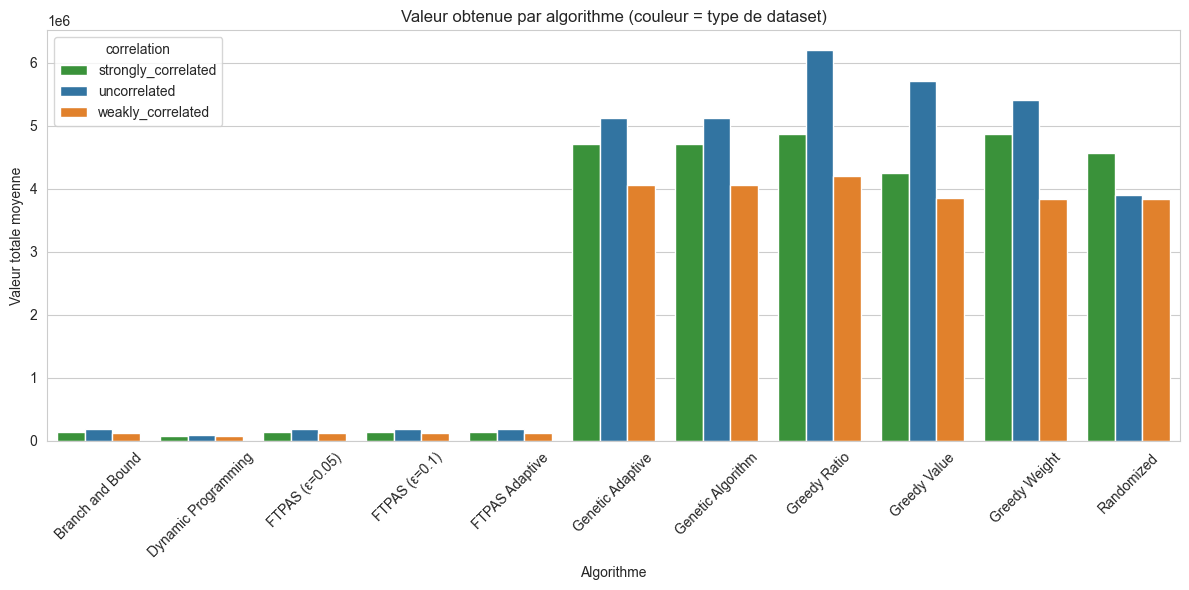

In [63]:
# Graphique 1 : Qualité (valeur totale) par algorithme, couleur = correlation
if results_df is not None:
    df = results_df.copy()
    # moyenne valeur par algorithme x correlation
    agg = df.groupby(['algorithm', 'correlation'])['value'].mean().reset_index()
    
    plt.figure(figsize=(12,6))
    sns.barplot(data=agg, x='algorithm', y='value', hue='correlation',
                palette={'uncorrelated':'#1f77b4','weakly_correlated':'#ff7f0e','strongly_correlated':'#2ca02c'})
    plt.xlabel('Algorithme')
    plt.ylabel('Valeur totale moyenne')
    plt.title('Valeur obtenue par algorithme (couleur = type de dataset)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("results_df non chargé. Exécutez d'abord la cellule qui charge 'benchmark_results.csv'.")

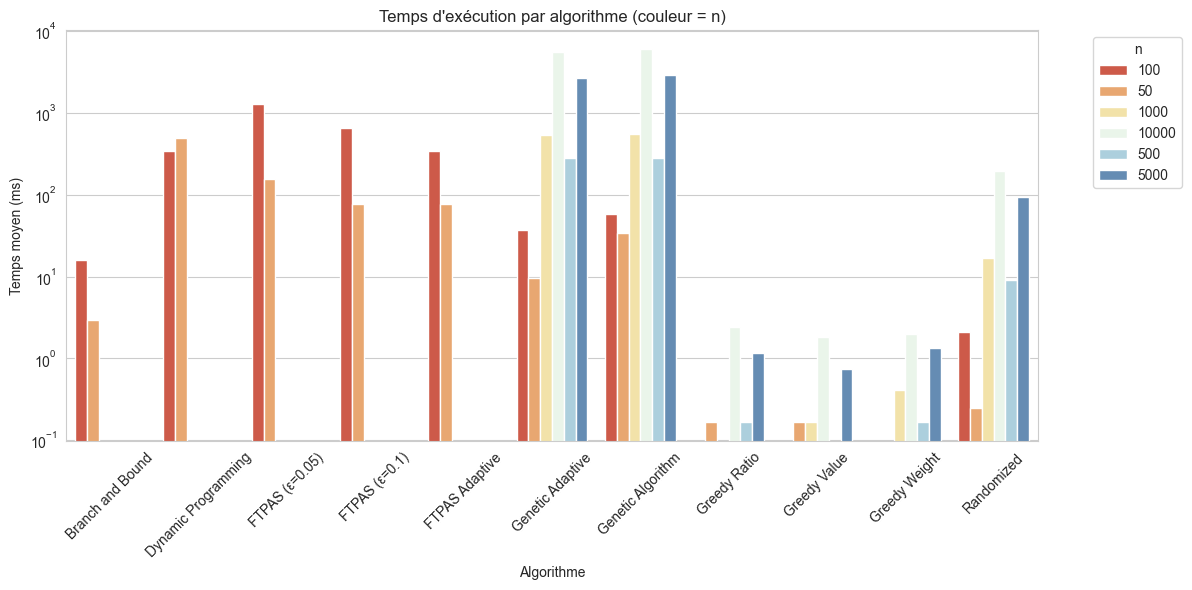

In [64]:
# Graphique 2 : Temps d'exécution (ms) par algorithme, couleur = taille n
if results_df is not None:
    df = results_df.copy()
    # convertir n en string pour la hue (pour une couleur distincte par taille)
    df['n_str'] = df['n'].astype(str)
    
    # moyenne time par algorithme x n
    agg_time = df.groupby(['algorithm', 'n_str'])['time_ms'].mean().reset_index()
    
    plt.figure(figsize=(12,6))
    sns.barplot(data=agg_time, x='algorithm', y='time_ms', hue='n_str',
                palette=sns.color_palette('RdYlBu', n_colors=len(agg_time['n_str'].unique())))
    plt.xlabel('Algorithme')
    plt.ylabel('Temps moyen (ms)')
    plt.title('Temps d\'exécution par algorithme (couleur = n)')
    plt.yscale('log')
    plt.xticks(rotation=45)
    plt.legend(title='n', bbox_to_anchor=(1.05,1), loc='upper left')
    plt.tight_layout()
    plt.show()
else:
    print("results_df non chargé. Exécutez d'abord la cellule qui charge 'benchmark_results.csv'.")

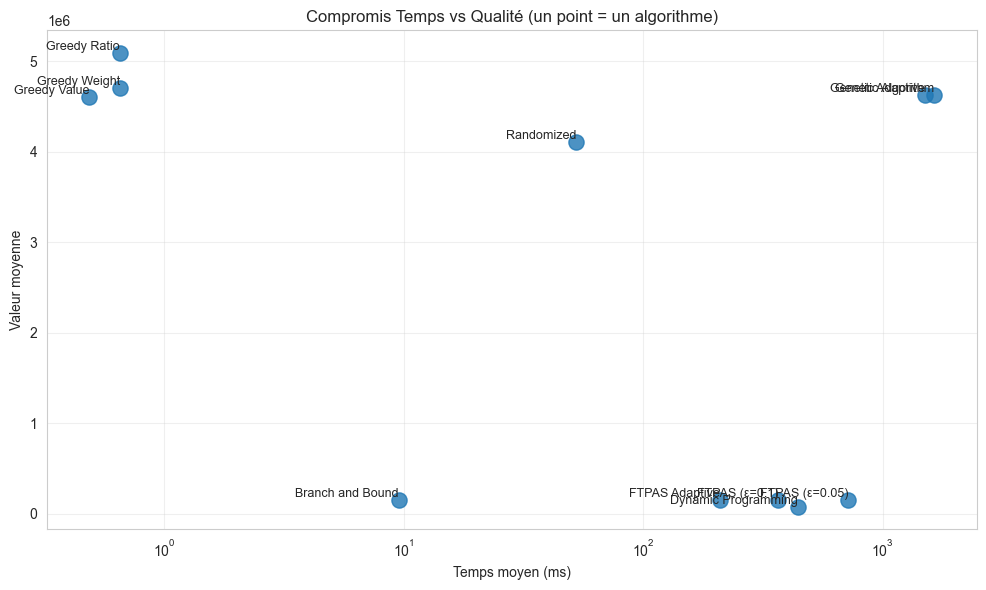

In [65]:
# Graphique 3 : Scatter Temps (X) vs Valeur (Y), 1 point = 1 algorithme (moyennes), annoté
if results_df is not None:
    df = results_df.copy()
    # prendre la moyenne temps et valeur par algorithme
    summary = df.groupby('algorithm').agg({'time_ms':'mean','value':'mean'}).reset_index()
    
    plt.figure(figsize=(10,6))
    plt.scatter(summary['time_ms'], summary['value'], s=120, alpha=0.8)
    for i, row in summary.iterrows():
        plt.text(row['time_ms'], row['value'], row['algorithm'], fontsize=9,
                 verticalalignment='bottom', horizontalalignment='right')
    plt.xscale('log')
    plt.xlabel('Temps moyen (ms)')
    plt.ylabel('Valeur moyenne')
    plt.title('Compromis Temps vs Qualité (un point = un algorithme)')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("results_df non chargé. Exécutez d'abord la cellule qui charge 'benchmark_results.csv'.")